# Infinite Data Stream

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`


This example shows the capabilities of `RxInfer` to perform Bayesian inference on real-time signals. As usual, first, we start with importing necessary packages:

In [2]:
using RxInfer, Plots, Random, StableRNGs

For demonstration purposes we will create a synthetic environment that has a hidden underlying signal, which we cannot observer directly. Instead, we will observe a noised realisation of this hidden signal:

In [3]:
mutable struct Environment
    rng                   :: AbstractRNG
    current_state         :: Float64
    observation_precision :: Float64
    history               :: Vector{Float64}
    observations          :: Vector{Float64}
    
    Environment(current_state, observation_precision; seed = 123) = begin 
         return new(StableRNG(seed), current_state, observation_precision, [], [])
    end
end

function getnext!(environment::Environment)
    environment.current_state = environment.current_state + 1.0
    nextstate  = 10sin(0.1 * environment.current_state)
    observation = rand(NormalMeanPrecision(nextstate, environment.observation_precision))
    push!(environment.history, nextstate)
    push!(environment.observations, observation)
    return observation
end

function gethistory(environment::Environment)
    return environment.history
end

function getobservations(environment::Environment)
    return environment.observations
end

getobservations (generic function with 1 method)

## Model specification

We assume that we don't know the shape of our signal in advance. So we try to fit a simple gaussian random walk with unknown observation noise:

In [4]:
@model function kalman_filter(x_prev_mean, x_prev_var, τ_shape, τ_rate, y)
    x_prev ~ Normal(mean = x_prev_mean, variance = x_prev_var)
    τ ~ Gamma(shape = τ_shape, rate = τ_rate)

    # Random walk with fixed precision
    x_current ~ Normal(mean = x_prev, precision = 1.0)
    y ~ Normal(mean = x_current, precision = τ)
    
end

# We assume the following factorisation between variables 
# in the variational distribution
@constraints function filter_constraints()
    q(x_prev, x_current, τ) = q(x_prev, x_current)q(τ)
end

filter_constraints (generic function with 1 method)

## Prepare environment

In [5]:
initial_state         = 0.0
observation_precision = 0.1

0.1

After we have created the environment we can observe how our signal behaves:

In [6]:
testenvironment = Environment(initial_state, observation_precision);

animation = @animate for i in 1:100
    getnext!(testenvironment)
    
    history = gethistory(testenvironment)
    observations = getobservations(testenvironment)
    
    p = plot(size = (1000, 300))
    
    p = plot!(p, 1:i, history[1:i], label = "Hidden signal")
    p = scatter!(p, 1:i, observations[1:i], ms = 4, alpha = 0.7, label = "Observation")
end

gif(animation, "../pics/infinite-data-stream.gif", fps = 24, show_msg = false);

![](../pics/infinite-data-stream.gif)

## Filtering on static dataset

`RxInfer` is flexible and allows for running inference both on real-time and static datasets. In the next section we show how to perform the filtering procedure on a static dataset. We also will verify our inference procedure by checking on the Bethe Free Energy values:

In [7]:
n                  = 300
static_environment = Environment(initial_state, observation_precision);

for i in 1:n
    getnext!(static_environment)
end

static_history      = gethistory(static_environment)
static_observations = getobservations(static_environment);
static_datastream   = from(static_observations) |> map(NamedTuple{(:y,), Tuple{Float64}}, (d) -> (y = d, ));

In [8]:
function run_static(environment, datastream)
    
    # `@autoupdates` structure specifies how to update our priors based on new posteriors
    # For example, every time we have updated a posterior over `x_current` we update our priors
    # over `x_prev`
    autoupdates = @autoupdates begin 
        x_prev_mean, x_prev_var = mean_var(q(x_current))
        τ_shape = shape(q(τ))
        τ_rate = rate(q(τ))
    end
    
    init = @initialization begin
        q(x_current) = NormalMeanVariance(0.0, 1e3) 
        q(τ) = GammaShapeRate(1.0, 1.0)
    end

    engine = infer(
        model          = kalman_filter(),
        constraints    = filter_constraints(),
        datastream     = datastream,
        autoupdates    = autoupdates,
        returnvars     = (:x_current, ),
        keephistory    = 10_000,
        historyvars    = (x_current = KeepLast(), τ = KeepLast()),
        initialization = init,
        iterations     = 10,
        free_energy    = true,
        autostart      = true,
    )
    
    return engine
end

run_static (generic function with 1 method)

In [9]:
result = run_static(static_environment, static_datastream);

In [10]:
static_inference = @animate for i in 1:n
    estimated = result.history[:x_current]
    p = plot(1:i, mean.(estimated[1:i]), ribbon = var.(estimated[1:n]), label = "Estimation")
    p = plot!(static_history[1:i], label = "Real states")    
    p = scatter!(static_observations[1:i], ms = 2, label = "Observations")
    p = plot(p, size = (1000, 300), legend = :bottomright)
end

gif(static_inference, "../pics/infinite-data-stream-inference.gif", fps = 24, show_msg = false);

![](../pics/infinite-data-stream-inference.gif)

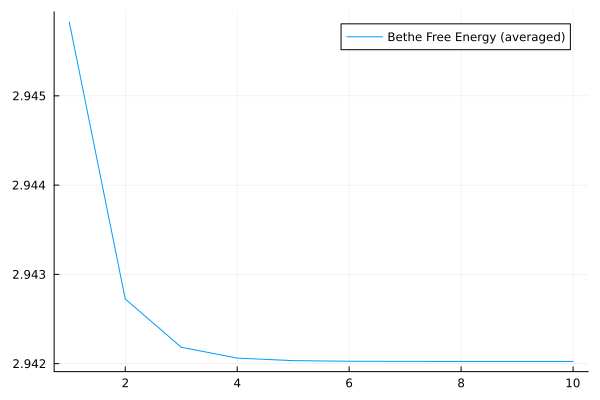

In [11]:
plot(result.free_energy_history, label = "Bethe Free Energy (averaged)") 

## Filtering on realtime dataset

Next lets create a "real" infinite stream. We use `timer()` observable from `Rocket.jl`to emulate real-world scenario. In our example we are going to generate a new data point every `~41ms` (24 data points per second). For demonstration purposes we force stop after `n` data points, but there is no principled limitation to run inference indefinite:

In [12]:
function run_and_plot(environment, datastream)
    
    # `@autoupdates` structure specifies how to update our priors based on new posteriors
    # For example, every time we have updated a posterior over `x_current` we update our priors
    # over `x_prev`
    autoupdates = @autoupdates begin 
        x_prev_mean, x_prev_var = mean_var(q(x_current))
        τ_shape = shape(q(τ))
        τ_rate = rate(q(τ))
    end
    
    posteriors = []
    
    plotfn = (q_current) -> begin 
        IJulia.clear_output(true)
        
        push!(posteriors, q_current)

        p = plot(mean.(posteriors), ribbon = var.(posteriors), label = "Estimation")
        p = plot!(gethistory(environment), label = "Real states")    
        p = scatter!(getobservations(environment), ms = 2, label = "Observations")
        p = plot(p, size = (1000, 300), legend = :bottomright)

        display(p)
    end
    
    init = @initialization begin
        q(x_current) = NormalMeanVariance(0.0, 1e3)
        q(τ) = GammaShapeRate(1.0, 1.0)
    end

    engine = infer(
        model         = kalman_filter(),
        constraints   = filter_constraints(),
        datastream    = datastream,
        autoupdates   = autoupdates,
        returnvars    = (:x_current, ),
        initialization = init,
        iterations    = 10,
        autostart     = false,
    )
    
    qsubscription = subscribe!(engine.posteriors[:x_current], plotfn)
    
    RxInfer.start(engine)
    
    return engine
end

run_and_plot (generic function with 1 method)

In [13]:
# This example runs in our documentation pipeline, which does not support "real-time" execution context
# We skip this code if run not in Jupyter notebook (see below an example with gif)
engine = nothing 
if isdefined(Main, :IJulia)
    timegen      = 41 # 41 ms
    environment  = Environment(initial_state, observation_precision);
    observations = timer(timegen, timegen) |> map(Float64, (_) -> getnext!(environment)) |> take(n) # `take!` automatically stops after `n` observations
    datastream   = observations |> map(NamedTuple{(:y,), Tuple{Float64}}, (d) -> (y = d, ));
    engine = run_and_plot(environment, datastream)
end;

The plot above is fully interactive and we can stop and unsubscribe from our `datastream` before it ends:

In [14]:
if !isnothing(engine) && isdefined(Main, :IJulia)
    RxInfer.stop(engine)
    IJulia.clear_output(true)
end;